In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
np.random.seed(42)

In [3]:
IMAGE_HEIGHT = 30
IMAGE_WIDTH = 32
DEPTH = 142

In [4]:
def read_pgm(pgmf):
    """Return a raster of integers from a PGM as a list of lists."""
    assert pgmf.readline() == b'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        for y in range(width):
            raster.append(max(0.01, ord(pgmf.read(1)) / depth))
    return raster

In [5]:
def create_output(name):
    if 'left' in name:
        return [0.9, 0.1, 0.1, 0.1]
    elif 'right' in name:
        return [0.1, 0.9, 0.1, 0.1]
    elif 'straight' in name:
        return [0.1, 0.1, 0.9, 0.1]
    elif 'up' in name:
        return [0.1, 0.1, 0.1, 0.9]

In [6]:
def get_max( v):
    maximum = 0
    pos = -1

    for i in range(len(v)):
        if v[i] > maximum:
            maximum = v[i]
            pos = i
    
    return pos

def output_to_orientation(v):
    maximum = get_max(v)

    match maximum:
        case 0:
            return 'left'
        case 1:
            return 'right'
        case 2:
            return 'straight'
        case _:
            return 'up'

In [7]:
def instance_to_image(instance):
    image = []
    for i in range(IMAGE_HEIGHT):
        row = [x * DEPTH for x in instance[(i * IMAGE_WIDTH):((i + 1) * IMAGE_WIDTH)]]
        assert(len(row)) == IMAGE_WIDTH
        image.append(row)
    
    return image

In [8]:
train_file = 'train_files.txt'
validation_file = "validation_files.txt"
test_file = "test_files.txt"

def create_dataset(file):
    set = []
    with open(file, 'r') as file:
        for line in file:
            image = read_pgm(open(line[:-1], 'rb'))
            set.append([image, create_output(line)])   
    return set

train_set = create_dataset(train_file)
validation_set = create_dataset(validation_file)
test_set = create_dataset(test_file)

In [9]:
class Function:
    pass

class IdentityFunction(Function):

    def __call__(self, x):
        return x 
    
    def derivative(self, x):
        return 1 

class SigmoidFunction(Function):

    def __call__(self, x):
        return 1 / (1 + math.pow(math.e, -x))
    
    def derivative(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class SeluFunction(Function):

    def __init__(self, lambdaa = 1.0507, alpha = 1.6732):
        self.__lambda = lambdaa
        self.__alpha = alpha

    def __call__(self, x):
        if x >= 0:
            return self.__lambda * x
        
        return self.__lambda * self.__alpha * (math.exp(x) - 1)
    
    def derivative(self, x):
        if x >= 0:
            return self.__lambda
        
        return self.__lambda * self.__alpha * math.exp(x)

In [10]:
class Node:
    
    def __init__(self, no_weights, function = IdentityFunction(), lr = 0.03):
        self._weights =  list((0.1 * np.random.random_sample((1, no_weights + 1)) - 0.05)[0])
        self._nodes = []
        self._lr = lr 
        self._function = function
        self._no_weights = no_weights

    def addNode(self, node):
        self._nodes.append(node)
    
    def addNodes(self, nodes):
        for node in nodes:
            self.addNode(node)
    
    def get_weights(self):
        return self._weights
    
    def get_function(self):
        return self._function

    def set_lr(self, lr):
        self._lr = lr

    def apply(self, instance):
        assert len(self._weights) - 1 == len(instance)
        return self._function(self._weights[0] + sum([i * j for i, j in zip(self._weights[1:], instance)]))
    
    def derivative(self, instance):
        return self._function.derivative(self._weights[0] + sum([i * j for i, j in zip(self._weights[1:], instance)]))
    
    def update_weights(self, instance, error):
        assert len(self._weights[1:]) == len(instance)

        for j in range(1, self._no_weights):
            self._weights[j] = self._weights[j] + self._lr * error * instance[j - 1]

In [11]:
class InputNode(Node):
    def __init__(self, no_weights = 2, function = IdentityFunction(), lr = 0.03):
        super().__init__(no_weights, function, lr)
        self._weights = [0, 1]


In [12]:
class OutputNode(Node):
    def __init__(self, no_weights = 2, function = IdentityFunction(), lr = 0.03):
        super().__init__(no_weights, function, lr)
        self._error = None

    def reset_error(self):
        self._error = None

    def error(self, instance, target):
        if self._error != None:
            return self._error

        value = self.apply(instance)

        self._error = self._function.derivative(value) * (target - value)
        #self._error =  value * (1 - value) * (target - value) 
        return self._error
    
    def update_weights(self, instance, target):
        for j in range(1, self._no_weights):
            self._weights[j] = self._weights[j] + self._lr * self.error(instance, target) * instance[j - 1]

In [13]:
class Layer:

    def __init__(self, no_previous_nodes, no_nodes, function = IdentityFunction(), lr = 0.03, name = 'Layer'):
        self._nodes = [None] * no_nodes
        for i in range(no_nodes):
            self._nodes[i] = Node(no_previous_nodes, function, lr)

        self._next_layer = None
        self._no_weights = no_previous_nodes
        self._no_nodes = no_nodes
        self._name = name
        self._errors = None
    
    def get_name(self):
        return self._name

    def get_no_nodes(self):
        return self._no_nodes

    def get_no_weights(self):
        return self._no_weights
    
    def get_nodes(self):
        return self._nodes

    def get_weights(self):
        return [node.get_weights() for node in self._nodes]

    def get_next_layer(self):
        return self._next_layer

    def set_lr(self, lr):
        for node in self._nodes:
            node.set_lr(lr)
    
    def reset_error(self):
        self._errors = None

    def apply(self, instance):
        return [node.apply(instance) for node in self._nodes]
    
    def derivative(self, instance):
        return [node.derivative(instance) for node in self._nodes]
    
    def errors(self, instance, target = None):
        if self._errors != None:
            return self._errors

        errors = []
        next_errors = self._next_layer.errors(self.apply(instance), target)
        next_nodes = self._next_layer.get_nodes()

        assert len(next_nodes) == len(next_errors)

        for i in range(len(self._nodes)):
            derivative = self._nodes[i].derivative(instance)
            errors.append(derivative * sum([node.get_weights()[i + 1] * error for node, error in zip(next_nodes, next_errors)]))
        
        self._errors = errors
        return errors
    
    def update_weights(self, instance, target = None):
        errors = self.errors(instance, target)
        
        assert len(self._nodes) == len(errors)
        for node, error in zip(self._nodes, errors):
            node.update_weights(instance, error)

    def add_next_layer(self, layer):
        assert self._no_nodes == layer.get_no_weights()

        if self._no_nodes != layer.get_no_weights():
            raise Exception("Invalid number of nodes")

        self._next_layer = layer
        for node in self._nodes:
            node.addNodes(layer.get_nodes())

In [14]:

class InputLayer(Layer):

    def __init__(self, no_nodes, function = IdentityFunction(), lr = 0.03, no_previous_nodes = 0, name = 'Input'):
        super().__init__(no_previous_nodes, no_nodes, function, lr, name)

        self._nodes = [InputNode()] * no_nodes

In [15]:
class OutputLayer(Layer):
    def __init__(self, no_nodes, function = IdentityFunction(), lr = 0.03, no_previous_nodes = 0, name = 'Output'):
        super().__init__(no_previous_nodes, no_nodes, function, lr, name)

        self._nodes = [None] * no_nodes
        for i in range(no_nodes):
            self._nodes[i] = OutputNode(no_previous_nodes, function, lr)
    
    def reset_error(self):
        self._errors = None
        for node in self._nodes:
            node.reset_error()
    
    def errors(self, instance, targets = None):
        if self._errors != None:
            return self._errors

        self._errors = [node.error(instance, target) for node, target in zip(self.get_nodes(), targets)]
        return self._errors

    def update_weights(self, instance, targets):
        assert len(self._nodes) == len(targets)
        self.errors(instance, targets)

        for node, target in zip(self.get_nodes(), targets):
            node.update_weights(instance, target)

In [16]:
class Model:

    def __init__(self, lr = 0.03, epochs = 10):
        self.__first_layer = None 
        self.__lr = lr
        self.__epochs = epochs
    
    def add_layer(self, layer):
        layer.set_lr(self.__lr)
        if self.__first_layer == None:
            self.__first_layer = layer
        else:
            current_layer = self.__first_layer
            while current_layer.get_next_layer() != None:
                current_layer = current_layer.get_next_layer()
            current_layer.add_next_layer(layer)
    
    def get_input_layer_result(self, instance):
        return [node.apply([instance_value]) for node, instance_value in zip(self.__first_layer.get_nodes(), instance)]

    def get_weights(self):
        weights = []
        current_layer = self.__first_layer

        while current_layer != None:
            weights.append(current_layer.get_weights())
            current_layer = current_layer.get_next_layer()

        return weights

    def reset_error(self):
        current_layer = self.__first_layer.get_next_layer()

        while current_layer != None:
            current_layer.reset_error()
            current_layer = current_layer.get_next_layer()

    def apply(self, instance):
        current_instance = instance
        current_layer = self.__first_layer.get_next_layer()
        
        while current_layer != None:
            current_instance = current_layer.apply(current_instance)
            current_layer = current_layer.get_next_layer()
        
        return current_instance
    
    def get_output_weights(self):
        current_layer = self.__first_layer.get_next_layer()
        
        while current_layer.get_next_layer() != None:
            current_layer = current_layer.get_next_layer()
        
        return current_layer.get_weights()
    
    def updateWeightsModel(self, instance, target):
        layer = self.__first_layer.get_next_layer()

        inputs = [instance]
        layers = []
        contor = 0

        while layer != None:
            inputs.append(layer.apply(inputs[contor]))
            layers.append(layer)
            layer = layer.get_next_layer()
            contor += 1

        contor -= 1 

        while contor >= 0:
            layer = layers[contor]
            input = inputs[contor]
            
            if layer.get_next_layer() == None:
                layer.update_weights(input, target)
            else:
                layer.update_weights(input, None) 
            
            contor -= 1


    def accuracy(self, instances, targets):
        correct = 0
        for instance, target in zip(instances, targets):
            prediction = self.apply(instance)
            if get_max(prediction) == get_max(target):
                correct += 1
        
        return correct / len(instances)


    def fit(self, instances, targets):
        accuracy_list = []
        epochs_list = []
        for i in range(self.__epochs):
            for instance, target in zip(instances, targets):
                self.updateWeightsModel(instance, target)

                self.reset_error()

            accuracy_list.append(self.accuracy(instances, targets))
            epochs_list.append(i)
        
        return [accuracy_list, epochs_list]

In [17]:
train_instances = [element[0] for element in train_set]
train_targets = [element[1] for element in train_set]

In [18]:
model = Model(epochs = 50, lr = 0.15)
model.add_layer(InputLayer(IMAGE_HEIGHT * IMAGE_WIDTH))
model.add_layer(Layer(no_previous_nodes = IMAGE_WIDTH * IMAGE_HEIGHT, no_nodes = 32, function = SigmoidFunction(), name = 'Hidden 1'))
model.add_layer(OutputLayer(no_previous_nodes = 32, no_nodes = 4, function = SigmoidFunction(), name = 'Output'))

In [19]:
[accuracy, epochs] = model.fit(train_instances, train_targets)

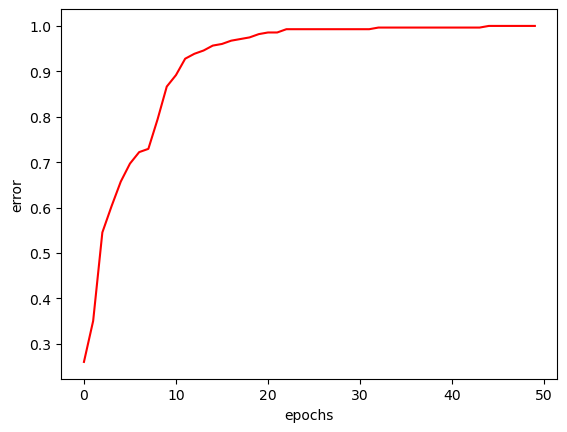

In [20]:
plt.xlabel('epochs')
plt.ylabel('error')

plt.plot(epochs, accuracy, 'r')
plt.show()

In [21]:
model.accuracy(train_instances,train_targets)

1.0

In [22]:
validation_instances = [element[0] for element in validation_set]
validation_targets = [element[1] for element in validation_set]
model.accuracy(validation_instances, validation_targets)

0.920863309352518

In [23]:
test_instances = [element[0] for element in test_set]
test_targets = [element[1] for element in test_set]
model.accuracy(test_instances, test_targets)

0.9230769230769231

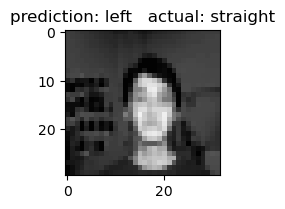

In [24]:
for instance, target in zip(test_instances, test_targets):
    prediction = output_to_orientation(model.apply(instance))
    orientation = output_to_orientation(target)
    if prediction != orientation:
        image = instance_to_image(instance)
        plt.figure(figsize=(2, 2))
        plt.title('prediction: ' + prediction + "   actual: " + orientation)
        plt.imshow(image, cmap = 'gray', vmin = 0, vmax = DEPTH)
        break